<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

I'm downloading btc price from https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv

and eth price from https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv

and gold price from https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical

In [3]:
!gdown 11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
!gdown 1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
!gdown 1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv

Downloading...
From: https://drive.google.com/uc?id=11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
To: /content/gold-price.csv
100% 116k/116k [00:00<00:00, 78.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
To: /content/btc-price.csv
100% 285k/285k [00:00<00:00, 92.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
To: /content/eth-price.csv
100% 186k/186k [00:00<00:00, 87.5MB/s]


# Preprocess *data*

In [134]:
from tensorflow.python.ops.ragged.row_partition import np
from functools import reduce 
import pandas as pd
from datetime import datetime

gold_csv = pd.read_csv('gold-price.csv')
btc_csv = pd.read_csv('btc-price.csv')
eth_csv = pd.read_csv('eth-price.csv')

if len(btc_csv) != len(eth_csv):
  print("WARNING. Length are different!")



data = []

index = 1
for i in range(0, len(gold_csv)):
  if i >= len(btc_csv) or i >= len(eth_csv):
    break
  gold_time = datetime.strptime(gold_csv.iloc[i, 0], "%m/%d/%Y").timestamp()
  gold_price = float(gold_csv.iloc[i, 3]) # open price  
  while True: 
    if index >= len(btc_csv) or index >= len(eth_csv):
      break   
    btc_time = float(btc_csv.iloc[index].name[0])
    if btc_time < gold_time:      
      break   
    btc_price = float(btc_csv.iloc[index].name[3]) # open price    
    eth_price = float(eth_csv.iloc[index].name[3]) # open price
    index += 1
    data.append([btc_price, eth_price, gold_price])
data = np.array(data)


WARNING. Length are different!


# Scaling

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

x_train = []
y_train = []
for i in range(90, len(data)):
  x_train.append(np.reshape(data[i - 90: i], (1, 270)))
  y_train.append(data[i][0])


x_train = np.reshape(x_train, (len(x_train), 90, 3))
y_train = np.reshape(y_train, (len(y_train)))


# Build Model and Train

In [136]:
from tensorflow.keras import layers
from tensorflow import keras


model = keras.Sequential()

model.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 1))

model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=30, batch_size=32)
model.summary()

Epoch 1/30
55/55 [==============================] - 16s 164ms/step - loss: 0.0122
Epoch 2/30
55/55 [==============================] - 9s 161ms/step - loss: 0.0051
Epoch 3/30
55/55 [==============================] - 9s 164ms/step - loss: 0.0039
Epoch 4/30
55/55 [==============================] - 11s 194ms/step - loss: 0.0036
Epoch 5/30
55/55 [==============================] - 13s 230ms/step - loss: 0.0040
Epoch 6/30
55/55 [==============================] - 11s 202ms/step - loss: 0.0035
Epoch 7/30
55/55 [==============================] - 12s 218ms/step - loss: 0.0039
Epoch 8/30
55/55 [==============================] - 10s 191ms/step - loss: 0.0030
Epoch 9/30
55/55 [==============================] - 10s 188ms/step - loss: 0.0034
Epoch 10/30
55/55 [==============================] - 11s 206ms/step - loss: 0.0040
Epoch 11/30
55/55 [==============================] - 11s 192ms/step - loss: 0.0028
Epoch 12/30
55/55 [==============================] - 11s 197ms/step - loss: 0.0029
Epoch 13/30
55/

# Predict

1/1 [==============================] - 0s 124ms/step
0.0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


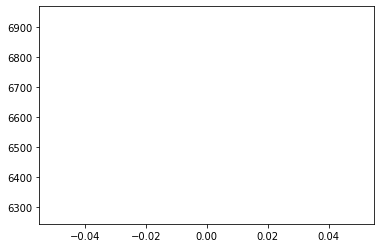

In [157]:
import matplotlib.pyplot as plt

x = np.array([])
x = np.append(x, np.reshape(data[len(data) - 90: len(data)], (1, 270)))
x = np.reshape(x, (1, 90, 3))
res_array = np.array([])
y_array = np.array([])
for i in range(1, 2):
  res = model.predict(x)  
  y_array = np.append(y_array, scaler.inverse_transform(np.reshape([res[0], data[len(data) - 1][1] , data[len(data) - 1][2]], (1, 3)))[0][0])
  res_array = np.append(res_array, res[0])
  res_array = np.append(res_array, data[len(data) - 1][1:])    
  x = np.array([])
  x = np.append(x, np.reshape(np.append(data[len(data) - 90 + i: len(data)], res_array), (1, 270)))
  x = np.reshape(x, (1, 90, 3))


plt.plot(y_array, color='green')
print((y_array[len(y_array) - 1] - y_array[0])/y_array[0])